In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)


# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression

# estudo árvores
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# estudo SVM
from sklearn.svm import SVC

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

# exportar o modelo
from joblib import dump

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS, MODELO_FINAL
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models_rus import RANDOM_STATE
from src.models_rus import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int8  
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int16 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int8  
 6   Education                 1470 non-null   int8  
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int8  
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int8  
 11  JobInvolvement            1470 non-null   int8  
 12  JobLevel                  1470 non-null   int8  
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [4]:
colunas_categoricas_nao_ordenadas = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

colunas_categoricas_ordenadas = [
    "Education",
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]

coluna_alvo = ["Attrition"]

colunas_numericas = [
    coluna for coluna in df.columns if coluna not in (
        colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas + coluna_alvo
    )
]

colunas_numericas

['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [5]:
colunas_numericas_min_max = [
    "DailyRate",
    "HourlyRate",
    "MonthlyRate",
]

colunas_numericas_std = ["Age",]

colunas_numericas_power_transform = [
    coluna for coluna in colunas_numericas if coluna not in (
        colunas_numericas_min_max + colunas_numericas_std
    )
]

colunas_numericas_power_transform

['DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [6]:
X = df.drop(columns=coluna_alvo)
y = df[coluna_alvo]

In [7]:
y[:5]

,Attrition
0,Yes
1,No
2,Yes
3,No
4,No


In [8]:
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())

y[:10]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [9]:
le.classes_

array(['No', 'Yes'], dtype=object)

In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [11]:
preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories="auto"), colunas_categoricas_ordenadas),
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories="auto"), colunas_categoricas_ordenadas),
        ("min_max", MinMaxScaler(), colunas_numericas_min_max),
        ("stdscaler", StandardScaler(), colunas_numericas_std),
        ("power_transform", PowerTransformer(), colunas_numericas_power_transform),
    ]
)

In [12]:
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(),
    },
    "DecisionTreeClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": DecisionTreeClassifier(),
    },
    "LGBMClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
        ),
    },
    "XGBClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
        ),
    },
    "SVC": {
        "preprocessor": preprocessamento,
        "classificador": SVC(),
    },
    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier(),
    },
}

In [13]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.010526,0.012037,0.496599,0.514736,0.26,0.171053,0.541667,0.529217,0.172008,0.022563
1,DummyClassifier,0.008536,0.012536,0.465986,0.454522,0.211055,0.139073,0.4375,0.57063,0.187063,0.021072
2,DummyClassifier,0.006518,0.01176,0.513605,0.50379,0.243386,0.161972,0.489362,0.512404,0.163338,0.018277
3,DummyClassifier,0.006511,0.011263,0.472789,0.470885,0.221106,0.144737,0.468085,0.51697,0.16468,0.017774
4,DummyClassifier,0.007511,0.01053,0.506803,0.448058,0.189944,0.128788,0.361702,0.457188,0.150101,0.018041
5,LogisticRegression,0.128224,0.036078,0.707483,0.724593,0.455696,0.327273,0.75,0.798103,0.548634,0.164302
6,LogisticRegression,0.064606,0.036061,0.768707,0.744411,0.5,0.386364,0.708333,0.825373,0.565305,0.100667
7,LogisticRegression,0.062597,0.036053,0.72449,0.749892,0.477419,0.342593,0.787234,0.846326,0.65278,0.09865
8,LogisticRegression,0.063624,0.036067,0.751701,0.748859,0.48951,0.364583,0.744681,0.834783,0.608646,0.09969
9,LogisticRegression,0.072891,0.038088,0.758503,0.735679,0.481752,0.366667,0.702128,0.776036,0.572919,0.110979


In [14]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.00792,0.011625,0.491156,0.478398,0.225098,0.149124,0.459663,0.517282,0.167438,0.019546
DecisionTreeClassifier,0.017925,0.024581,0.664626,0.660341,0.385924,0.273912,0.653989,0.660341,0.237081,0.042505
KNeighborsClassifier,0.053333,0.461786,0.730612,0.665559,0.405845,0.31686,0.569592,0.728196,0.355607,0.515119
XGBClassifier,0.272742,0.026262,0.714286,0.700185,0.434119,0.319391,0.679344,0.773475,0.444256,0.299004
LGBMClassifier,0.041476,0.027102,0.72381,0.715876,0.451201,0.33224,0.704255,0.79084,0.482381,0.068578
LogisticRegression,0.078388,0.036469,0.742177,0.740687,0.480876,0.357496,0.738475,0.816124,0.589657,0.114858
SVC,0.061504,0.05736,0.765306,0.747714,0.500218,0.383697,0.72172,0.826207,0.61304,0.118864


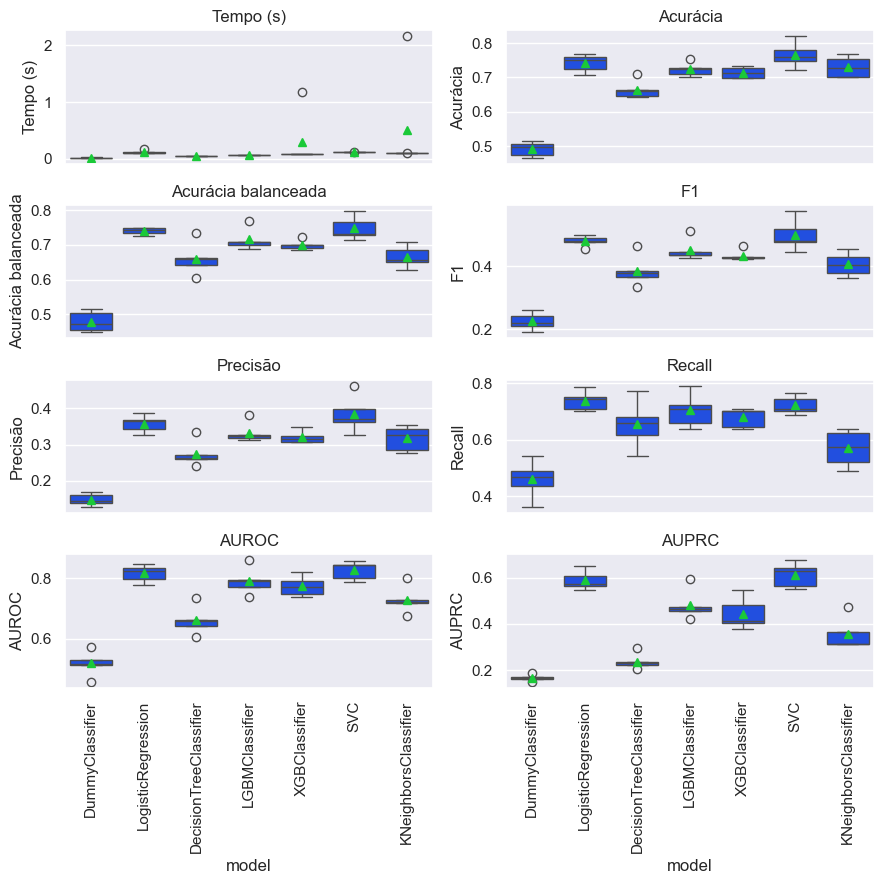

In [15]:
plot_comparar_metricas_modelos(df_resultados)

In [16]:
param_grid = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2", "elasticnet", None],
    "clf__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
}

In [17]:
clf = LogisticRegression(solver="saga", random_state=RANDOM_STATE)

grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, preprocessamento, refit_metric="average_precision",
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        RandomUnderSampler(random_state=42)),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [18]:
grid_search.fit(X, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


D:\AmbientesVirtuais\machlearhousing\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        RandomUnderSampler(random_state=42)),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [19]:
grid_search.best_params_

{'clf__C': 0.1, 'clf__l1_ratio': 0.1, 'clf__penalty': 'elasticnet'}

In [20]:
grid_search.best_score_

np.float64(0.6174426856945511)

In [21]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__C', 'param_clf__l1_ratio', 'param_clf__penalty', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_te

In [22]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Education',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'JobInvolvement', 'JobLevel',
                                                   'PerformanceRating',
                                                   'RelationshipSatis...
                                                  ['DistanceFromHome',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.1, l1_ratio=0.1, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [23]:
grid_search.best_index_

np.int64(2)

In [24]:
grid_search.cv_results_["mean_test_average_precision"][grid_search.best_index_]

np.float64(0.6174426856945511)

In [25]:
grid_search.cv_results_["mean_test_accuracy"][grid_search.best_index_]

np.float64(0.7455782312925171)

In [26]:
colunas_test = [coluna for coluna in df_resultados.columns if coluna.startswith("test")]
colunas_test

['test_accuracy',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision']

In [27]:
colunas_test_mean = ["mean_" + coluna for coluna in colunas_test]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [28]:
for coluna in colunas_test_mean:
    print(f"{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}")

mean_test_accuracy: 0.7455782312925171
mean_test_balanced_accuracy: 0.7427915648568149
mean_test_f1: 0.4836919077866698
mean_test_precision: 0.36005367773384245
mean_test_recall: 0.7386524822695035
mean_test_roc_auc: 0.819642474673304
mean_test_average_precision: 0.6174426856945511


In [29]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_["clf"].coef_[0],
    grid_search.best_estimator_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
ordinal__JobInvolvement,-0.495667
power_transform__MonthlyIncome,-0.389700
one_hot__EducationField_Life Sciences,-0.268742
one_hot__Department_Research & Development,-0.252369
power_transform__TotalWorkingYears,-0.243814
ordinal__RelationshipSatisfaction,-0.215038
ordinal__StockOptionLevel,-0.204987
power_transform__YearsWithCurrManager,-0.200748
power_transform__TrainingTimesLastYear,-0.191032
power_transform__YearsInCurrentRole,-0.177019


In [30]:
coefs.query("coeficiente == 0")

,coeficiente
ordinal__PerformanceRating,0.0
one_hot__MaritalStatus_Married,0.0
one_hot__EducationField_Medical,0.0
one_hot__BusinessTravel_Travel_Rarely,0.0
stdscaler__Age,0.0
min_max__MonthlyRate,0.0
min_max__HourlyRate,0.0
one_hot__JobRole_Human Resources,0.0
one_hot__EducationField_Other,0.0


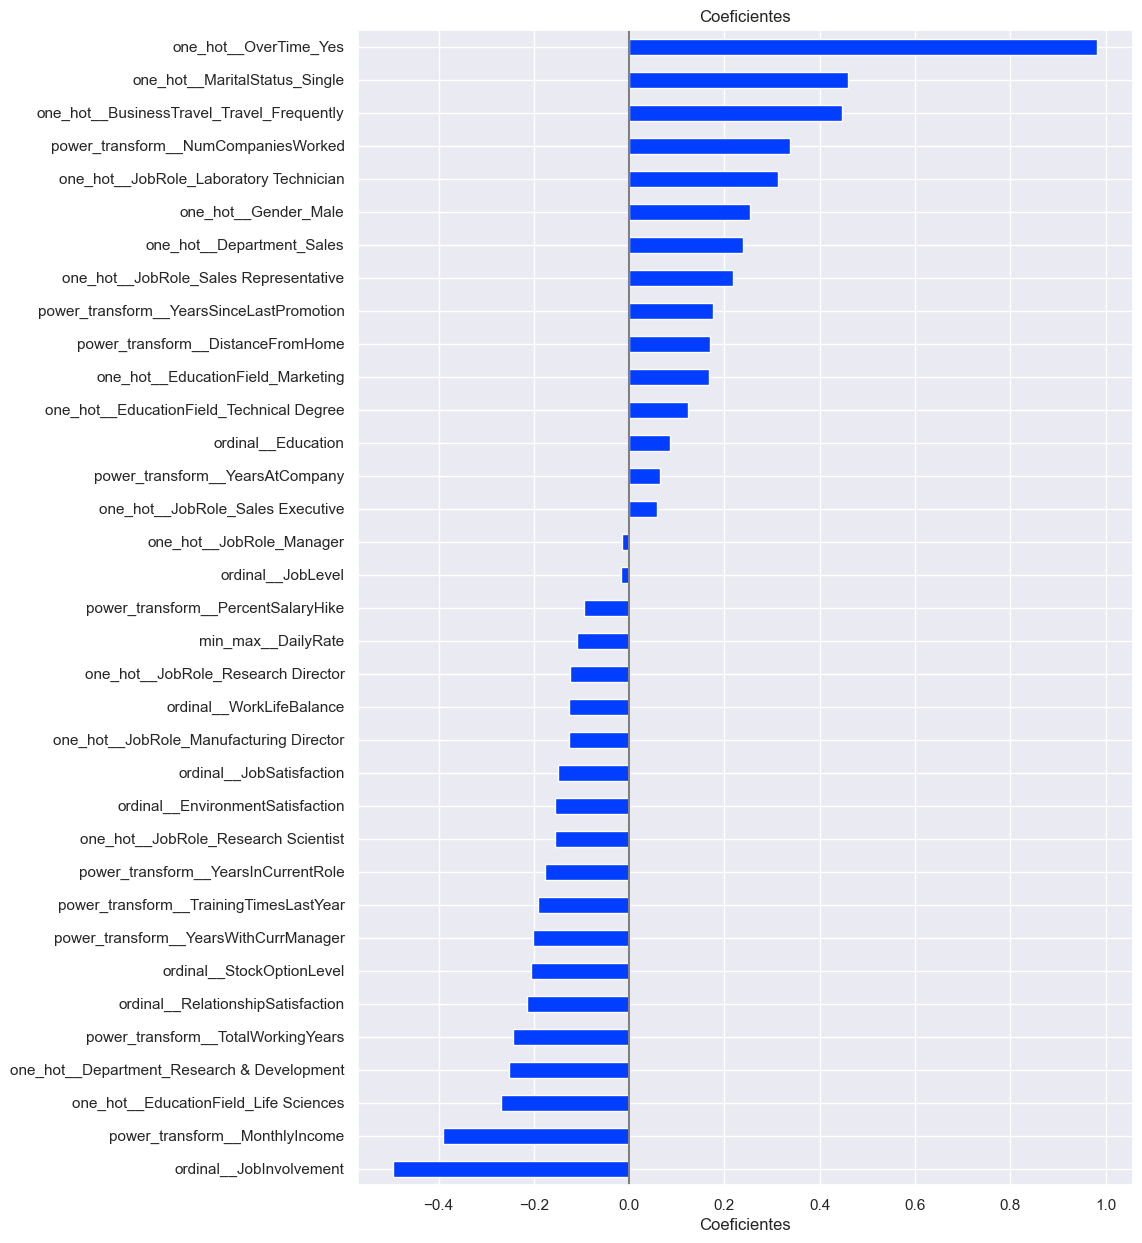

In [31]:
plot_coeficientes(coefs.query("coeficiente != 0"))

Os coeficientes $w_i$ em uma regressão logística não são interpretados diretamente como em uma regressão linear. Em vez disso, eles representam o **logaritmo do odds ratio** associado a cada variável.

- **Odds (Chances):** Razão entre a probabilidade do evento ocorrer e a probabilidade de não ocorrer.

  $$
  \text{Odds} = \frac{\text{Probabilidade do Evento}}{1 - \text{Probabilidade do Evento}}
  $$

- **Odds Ratio:** Medida de quanto as chances mudam com uma unidade de aumento na variável independente.

- **Coeficiente ($w_i$):** Representa a mudança nos **log-odds** do resultado por unidade de aumento na variável $X_i$.

  $$
  \text{Log-Odds} = w_0 + w_1X_1 + w_2X_2 + \dots + w_nX_n
  $$

Para interpretar os coeficientes em termos mais intuitivos, podemos calcular o **exponencial do coeficiente**:

$$
\text{Odds Ratio} = e^{w_i}
$$

- **Interpretação do Odds Ratio:**
  - **Valor > 1:** Aumenta as chances do evento ocorrer.
  - **Valor = 1:** Não afeta as chances.
  - **Valor < 1:** Diminui as chances do evento ocorrer.


Imagine que estamos modelando a probabilidade de um paciente ter uma doença com base na idade e no hábito de fumar.

$$
\text{Log-Odds} = w_0 + w_1 (\text{Idade}) + w_2 (\text{Fumante})
$$

Suponha que obtivemos os seguintes coeficientes:

- $w_0 = -2$
- $w_1 = 0{,}05$
- $w_2 = 1{,}5$

1. **Coeficiente da Idade ($w_1 = 0{,}05$, variável contínua):**

   - **Log-Odds:** Para cada aumento de 1 ano na idade, o log-odds de ter a doença aumenta em 0,05.
   - **Odds Ratio:** $e^{0{,}05} \approx 1{,}051$
   - **Interpretação:** Cada ano adicional de idade aumenta as chances de ter a doença em aproximadamente **5,1%**.

2. **Coeficiente do Fumante ($w_2 = 1{,}5$, variável categórica):**

   - **Log-Odds:** Se o paciente é fumante (1), o log-odds de ter a doença aumenta em 1,5 em comparação com não fumantes (0).
   - **Odds Ratio:** $e^{1{,}5} \approx 4{,}48$
   - **Interpretação:** Fumantes têm **4,48 vezes** mais chances de ter a doença do que não fumantes.


In [32]:
coefs_odds = coefs.copy()
coefs_odds["coeficiente"] = np.exp(coefs_odds["coeficiente"])

coefs_odds

,coeficiente
ordinal__JobInvolvement,0.609165
power_transform__MonthlyIncome,0.677260
one_hot__EducationField_Life Sciences,0.764340
one_hot__Department_Research & Development,0.776958
power_transform__TotalWorkingYears,0.783633
ordinal__RelationshipSatisfaction,0.806511
ordinal__StockOptionLevel,0.814658
power_transform__YearsWithCurrManager,0.818119
power_transform__TrainingTimesLastYear,0.826107
power_transform__YearsInCurrentRole,0.837764


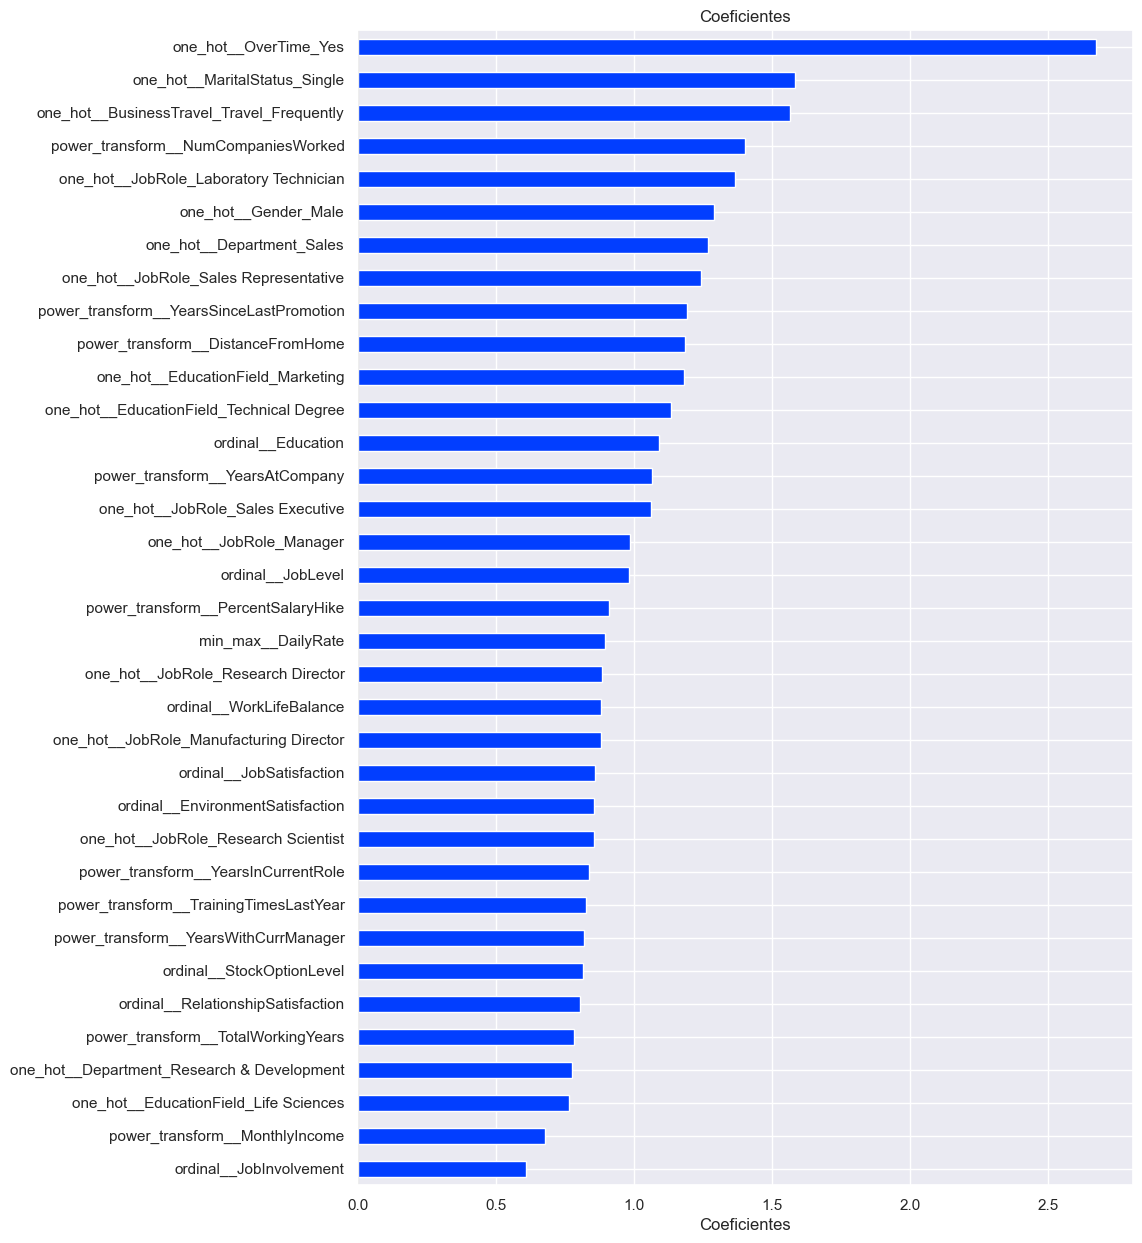

In [33]:
plot_coeficientes(coefs_odds.query("coeficiente != 1"))

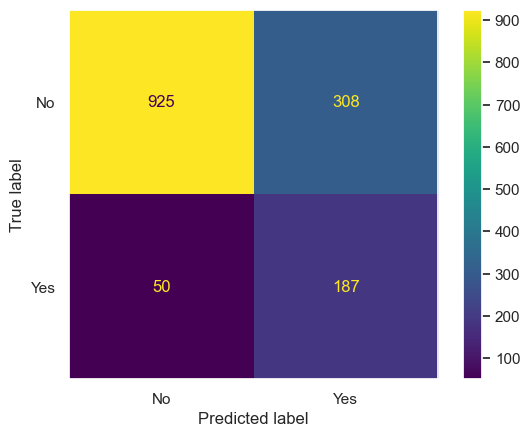

In [34]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
)
plt.grid(False)
plt.show()

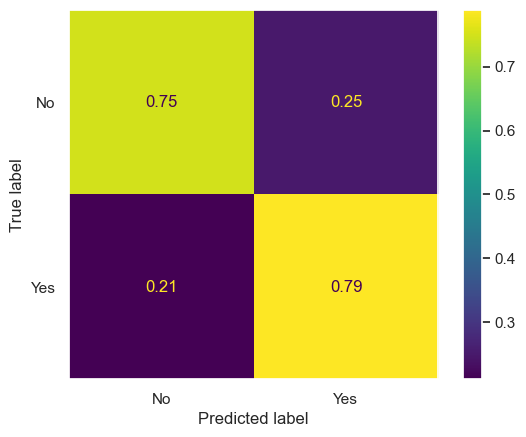

In [35]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    normalize="true",
)
plt.grid(False)
plt.show()

**Plano de ação**

- Avaliar os motivos que levam os funcionários a fazerem hora extra.
  - Mão de obra insuficiente
  - Falta de organização institucional
  - Falta de treinamento
  - Necessidade de investimento em tecnologia
- Possibilidade de diminuir as viagens de negócios.
  - Como isso afeta a equipe de vendas?
- Como a renda mensal de cada setor e nível da empresa se compara com o mercado?

In [36]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['D:\\Luigle\\OneDrive\\Documents\\Gleidson\\CiênciasdeDados\\22. Projeto - IBM attrition\\projeto_data_science_IBM_attrition\\modelos\\logistic_regression_rus.joblib']